# Readme

This script contains codes for figure generation described in the manuscript titled 'Benchmarking algorithms for joint integration of unpaired and paired single-cell RNA-seq and ATAC-seq data'. 

Please run steps described in evaluate_vary_situations_public.ipynb before this script. 

One summary plot is generated for each challenge. 



# Functions

In [1]:
# Run with an R kernel
library(dplyr)
library(ggplot2)
library(tidyverse)
library(ComplexHeatmap)
library(gridExtra)

plot_result <- function(dir_path,res_folder_filter=NULL,runtime_exists=T,prediction_exists=T,metric_file="metric.csv"){
    file_paths = list.files(dir_path,metric_file,recursive = T)
    res_df <- c()
    for(i in file_paths){
        m_i = read.csv(file.path(dir_path,i))
        elements = stringr::str_split(i,"/")[[1]]
        result_out = elements[2]
        method = elements[3]
        ct_ref = elements[4]
        orig = gsub("[0-9]*","",gsub("_.*","",elements[1]))
        var = gsub("[a-z]*[A-Z]*","",gsub("_.*","",elements[1]))
        rep = gsub(".*_","",elements[1])
        res_i = as.data.frame(c(m_i,c("orig"=orig,"var"=var,"rep"=rep,"method"=method,"out"=result_out,"ct_ref"=ct_ref)))
        res_df <- rbind(res_df,res_i)
    }
    res_df$var <- as.integer(res_df$var)
    
    # save intemediate result to output variable 
    res_all <- res_df
    if(runtime_exists){
        runtimes = list.files(dir_path,".*runtime.txt",recursive = T)
        res_df2 <- c()
        for(i in runtimes){
            m_i = read.table(file.path(dir_path,i))
            elements = stringr::str_split(i,"/")[[1]]
            result_out = elements[2]
            method = gsub("_.*","",elements[4])
            orig = gsub("[0-9]*","",gsub("_.*","",elements[1]))
            var = gsub("[a-z]*[A-Z]*","",gsub("_.*","",elements[1]))
            rep = gsub(".*_","",elements[1])
            res_i = as.data.frame(c(m_i,c("orig"=orig,"var"=var,"rep"=rep,"method"=method,"out"=result_out)))
            res_df2 <- rbind(res_df2,res_i)
        }

        rownames(res_df2) <- NULL
        res_df2<-data.frame(res_df2)
        res_df2$var<-as.integer(res_df2$var)
        colnames(res_df2)[1]="runtime"

        res_df2$runtime<-as.numeric(res_df2$runtime)
        
        res_all <- left_join(res_df,res_df2)
    }
    
    if(prediction_exists){
        prediciton_eval = list.files(dir_path,".*prediction_eval.txt",recursive = T)
        res_df3 <- c()
        for(i in prediciton_eval){
            m_i = read.csv(file.path(dir_path,i),header = F,sep='\t')
            vec = m_i[,2]
            names(vec) = unlist(m_i[1])
            elements = stringr::str_split(i,"/")[[1]]
            result_out = elements[2]
            method = elements[3]
            orig = gsub("[0-9]*","",gsub("_.*","",elements[1]))
            var = gsub("[a-z]*[A-Z]*","",gsub("_.*","",elements[1]))
            rep = gsub(".*_","",elements[1])
            res_i = t(data.frame(c(vec,"orig"=orig,"var"=var,"rep"=rep,"method"=method,"out"=result_out)))
            res_df3 <- rbind(res_df3,res_i)
        }

        rownames(res_df3) <- NULL
        res_df3<-data.frame(res_df3)
        res_df3$var<-as.integer(res_df3$var)
        res_df3$percent_recovered_50kb<-as.numeric(res_df3$percent_recovered_50kb)
        res_df3$f1<-as.numeric(res_df3$f1)
        res_all <- left_join(res_all,res_df3)
    }
    if(!is.null(res_folder_filter)){
        res_all = res_all %>% filter(out %in% res_folder_filter)
    }
   return(res_all)
}


# format unpaired integration method result, print out one average value despite changes in multiome cells, because they did not use the multiome cells 

format_unpaired_res <- function(res, n_times){
    output <- do.call(cbind,apply(unpaired_method_perform,2,function(x){
        y<-as.data.frame(x)
        do.call(cbind,rep(list(y),n_times))})
    )
    return(output)
}

# get observed (truth) peak-gene association accuracy result (percentage and F1)
## Assuming there is "truth_prediction_eval.txt" file under the dir_path folder. Read in results and format the table so it shows which repeat it is. 

get_pred_truth <- function(dir_path){
    prediciton_eval = list.files(dir_path,"truth_prediction_eval.txt",recursive = T)
    res_df3<-c()
    for(i in prediciton_eval){
        m_i = read.csv(file.path(dir_path,i),header = F,sep='\t')
        vec = m_i[,2]
        names(vec) = unlist(m_i[1])
        elements = stringr::str_split(i,"/")[[1]]
        result_out = elements[2]
        method = elements[3]
        orig = gsub("[0-9]*","",gsub("_.*","",elements[1]))
        var = gsub("[a-z]*[A-Z]*","",gsub("_.*","",elements[1]))
        rep = gsub(".*_","",elements[1])
        res_i = t(data.frame(c(vec,"orig"=orig,"var"=var,"rep"=rep,"method"=method,"out"=result_out)))
        res_df3 <- rbind(res_df3,res_i)
    }

    rownames(res_df3) <- NULL
    res_df3<-data.frame(res_df3)
    res_df3$var<-as.integer(res_df3$var)
    res_df3$percent_recovered_50kb<-as.numeric(res_df3$percent_recovered_50kb)
    res_df3$f1<-as.numeric(res_df3$f1)
    return(res_df3)
}





Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.5
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap

# Sceanrio 1

## PBMC

### Load result

In [5]:
dir_path = "dataset/multiome_pbmc_10k/pbmc_vary_cell_test/"

res_all<- plot_result(dir_path,res_folder_filter = c("results_single_mod","results_single_same_cell_number"),runtime_exists=T,prediction_exists=T)

res_all$log2_runtime <- log2(res_all$runtime)

unpaired_method_list<-c("seurat3","rfigr","rbindsc","rliger")
# for result in the results_single_same_cell_number folder, add "_2" to indicate that they belong to 'unpaired (multiome-split)' category
res_plot <- res_all %>% 
    filter(var %in% c(1000,3000,8000)) %>% 
    mutate(method_name = ifelse(out=="results_single_same_cell_number",paste0(method,"_2"),method)) %>%
    # assign method type 
    mutate(type = ifelse(out!="results_single_same_cell_number",
                         ifelse(method%in%unpaired_method_list,"Unpaired","Multiome-guided"),
                         "Unpaired_multiome_split"))

# select the metrics to be plotted 
metric_sel = c("ARI","NMI","ct_aws","clisi","b_saw","kbet","gconn","percent_recovered_50kb","f1",
               "log2_runtime")
# select the result file 
res_plot = res_plot %>% filter(ct_ref =="ct3_metric.csv")

# method name for display
method_names = c("MultiVI","Seurat v4", "Cobolt","Seurat v3","bindSC","FigR", "Liger",
                 "Seurat v3","bindSC","FigR", "Liger")
# order of methods 
row_order = c("multivi","seurat4","cobolt","seurat3","rbindsc","rfigr","rliger",
              "seurat3_2","rbindsc_2","rfigr_2","rliger_2")
names(method_names)  = row_order

# method type 
method_type = c(rep("Multiome-guided",3),rep("Unpaired",4),rep("Unpaired with \n Multiome-split",4))
names(method_type) <- row_order

# metric name for display 
title_list = c("ARI","NMI","Cell type ASW","cLisi", "Batch ASW","kBET","Graph \n connectivity", 
               "Peak-gene \n pair % recovered","F1","log2(Runtime)")
names(title_list)=metric_sel

# reformat 
res_plot_2 <- res_plot %>% 
    select(ARI:gconn,percent_recovered_50kb:log2_runtime,method_name,var) %>%
    gather(key = "metric_type",
               value = "value", -method_name,-var,)%>%
    mutate(method = method_name) %>%
    mutate(type=factor(method_type[method],levels = c("Unpaired","Unpaired with \n Multiome-split","Multiome-guided"))) %>% 
    mutate(method_name= factor(method_names[method],levels=unique(method_names))) %>% 
    mutate(metric_name = factor(title_list[metric_type],levels = title_list))

# get observed accuracy (data for the red dashed line)
plot_ref_accuracy = TRUE
truth_tbl <- get_pred_truth(dir_path)
truth_df <- data.frame(metric_name = factor(c("Peak-gene \n pair % recovered","F1"),
                                            levels=c("Peak-gene \n pair % recovered","F1")),
                       Z = as.numeric(round(colMeans(truth_tbl[,1:2]),digits=2)))
truth_df


ERROR: Error in UseMethod("left_join"): no applicable method for 'left_join' applied to an object of class "list"


### Summary plot

In [4]:
file_name <- "pbmc_single_mod_n_split_metric_summary19_7ct_w_observed.pdf"
folder_path <- "figures/metric_plots/"
dir.create(folder_path)

subplot_idx = list(c("ARI","NMI"),c("Cell type ASW","cLisi"),c("Batch ASW","kBET"),
                   c("Peak-gene \n pair % recovered","F1"),c('log2(Runtime)',"Graph \n connectivity"))

# add summarized values: unpaired method - summarize across all var (despite 1000/3000/8000 multiome cells); for others, summarize across repeats
res_plot_3 <- res_plot_2 %>% 
    group_by(metric_name,var,method) %>% 
    # mean after grouping by metric, method, and var
    dplyr::mutate(mean_var = mean(value),
                  sd_var = sd(value)) %>%
    group_by(metric_name,method) %>%
    # mean after grouping by metric and method
    dplyr::mutate(mean_method = mean(value),
                  sd_method = sd(value)) %>%
    mutate(mean_f = ifelse(type=="Unpaired",mean_method,mean_var),
           sd_f = ifelse(type=="Unpaired",0,sd_var))
x_interval = c(1000,3000,8000)

# set y limits 
ylim_list = list(c(0.2,1),c(0.4,0.9),c(0.5,0.8),c(0.8,1),c(0.6,1),c(0,1),c(0.25,0.5),c(0.25,0.45),c(0,1),c(6,14))
nbreaks = list(4,5,6,4,4,5,5,4,5,8)
counter=1

subplots = list()
for(i in 1:length(subplot_idx)){
    print(i)
    subplots[[i]] = res_plot_3 %>%  
            filter(metric_name %in% subplot_idx[[i]]) %>%  
            ggplot(.,aes(x=var,y=mean_f,group=method,col=method_name,shape=type)) + 
            geom_point(size=3) +
            geom_line() +
            geom_errorbar(aes(ymin=mean_f-sd_f, ymax=mean_f+sd_f),
                         position=position_dodge(0.05),alpha=0.2)+
            scale_shape_manual(values = c(15,16,17))+
            scale_x_continuous(breaks=x_interval) +
            facet_grid(cols = vars(type),rows=vars(metric_name),scales = "free_y", switch="y") +
            theme_light()+
            theme(strip.text.x = element_text(size = 30,angle=90,colour = "black"),
                  strip.text.y = element_text(size = 30,angle=90,colour = "black"),
                  axis.text.x  = element_text(size = 25,angle = 90),axis.text.y = element_text(size = 25),
                  axis.title.x = element_blank(),axis.title.y = element_blank(),
                  strip.background = element_blank(), strip.placement = "outside",
                  panel.spacing.y = unit(5, "lines"),panel.spacing.x = unit(2, "lines"),
                 panel.border=element_blank(), axis.line=element_line())+
    ggh4x::facetted_pos_scales(
        y = list(
            scale_y_continuous(limits = ylim_list[[counter]],n.breaks = nbreaks[[counter]]),
            scale_y_continuous(limits = ylim_list[[counter+1]],n.breaks = nbreaks[[counter+1]])

        )
    )
    counter = counter + 2
    if(plot_ref_accuracy){
        if("F1" %in% subplot_idx[[i]]){
            subplots[[i]] = subplots[[i]] +
                geom_hline(data = truth_df, aes(yintercept = Z),linetype =2,color="red")
        }
    }

}
subplots_no_bdg = lapply(subplots,function(x){x+theme(legend.position = "none")})
pcomb <- grid.arrange(grobs=subplots_no_bdg,nrow=1)


# function to extract legend from plot
get_only_legend <- function(plot) {
  plot_table <- ggplot_gtable(ggplot_build(plot))
  legend_plot <- which(sapply(plot_table$grobs, function(x){x$name}) == "guide-box")
  legend <- plot_table$grobs[[legend_plot]]
  return(legend)
}
                            
# extract legend from plot1 using above function
legend <- get_only_legend(subplots[[1]])   
                                                          
pdf(file.path(folder_path,file_name),width=35,height=15) 
grid.arrange(pcomb, legend, ncol = 2, widths = c(10, 1))
dev.off()

## BMMC

### Load result

In [5]:
#dir_path = "dataset/bmmc/bmmc_vary_cell_test/"
dir_path ="dataset/bmmc/bmmc_vary_cell_test/"
res_all<- plot_result(dir_path,res_folder_filter = c("results_single_mod","results_single_same_cell_number"),runtime_exists=T,prediction_exists=T)

res_all$log2_runtime <- log2(res_all$runtime)

unpaired_method_list<-c("seurat3","rfigr","rbindsc","rliger")
# for result in the results_single_same_cell_number folder, add "_2" to indicate that they belong to 'unpaired (multiome-split)' category
res_plot <- res_all %>% 
    filter(var %in% c(1000,2000,4000))%>%
    filter(ct_ref =="ct3_metric.csv") %>% 
    mutate(method_name = ifelse(out=="results_single_same_cell_number",paste0(method,"_2"),method)) %>%
    # assign method type 
    mutate(type = ifelse(out!="results_single_same_cell_number",
                         ifelse(method%in%unpaired_method_list,"Unpaired","Multiome-guided"),
                         "Unpaired_multiome_split"))

# select the metrics to be plotted 
metric_sel = c("ARI","NMI","ct_aws","clisi","b_saw","kbet","gconn","percent_recovered_50kb","f1",
               "log2_runtime")
# select the result file 
res_plot = res_plot %>% filter(ct_ref =="ct3_metric.csv")

# method name for display
method_names = c("MultiVI","Seurat v4", "Cobolt","Seurat v3","bindSC","FigR", "Liger",
                 "Seurat v3","bindSC","FigR", "Liger")
# order of methods 
row_order = c("multivi","seurat4","cobolt","seurat3","rbindsc","rfigr","rliger",
              "seurat3_2","rbindsc_2","rfigr_2","rliger_2")
names(method_names)  = row_order

# method type 
method_type = c(rep("Multiome-guided",3),rep("Unpaired",4),rep("Unpaired with \n Multiome-split",4))
names(method_type) <- row_order

# metric name for display 
title_list = c("ARI","NMI","Cell type ASW","cLisi", "Batch ASW","kBET","Graph \n connectivity", 
               "Peak-gene \n pair % recovered","F1","log2(Runtime)")
names(title_list)=metric_sel

# reformat 
res_plot_2 <- res_plot %>% 
    select(ARI:gconn,percent_recovered_50kb:log2_runtime,method_name,var) %>%
    gather(key = "metric_type",
               value = "value", -method_name,-var,)%>%
    mutate(method = method_name) %>%
    mutate(type=factor(method_type[method],levels = c("Unpaired","Unpaired with \n Multiome-split","Multiome-guided"))) %>% 
    mutate(method_name= factor(method_names[method],levels=unique(method_names))) %>% 
    mutate(metric_name = factor(title_list[metric_type],levels = title_list))

# get observed accuracy (data for the red dashed line)
plot_ref_accuracy = TRUE
truth_tbl <- get_pred_truth(dir_path)
truth_df <- data.frame(metric_name = factor(c("Peak-gene \n pair % recovered","F1"),
                                            levels=c("Peak-gene \n pair % recovered","F1")),
                       Z = as.numeric(round(colMeans(truth_tbl[,1:2]),digits=2)))
truth_df


Joining, by = c("orig", "var", "rep", "method", "out")
Joining, by = c("orig", "var", "rep", "method", "out")


metric_name,Z
<fct>,<dbl>
Peak-gene pair % recovered,0.23
F1,0.22


### Summary plot

Warning message in dir.create(folder_path):
“'figures/metric_plots' already exists”


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5


Warning message:
“Removed 86 rows containing missing values (geom_point).”
Warning message:
“Removed 86 row(s) containing missing values (geom_path).”


png 
  2

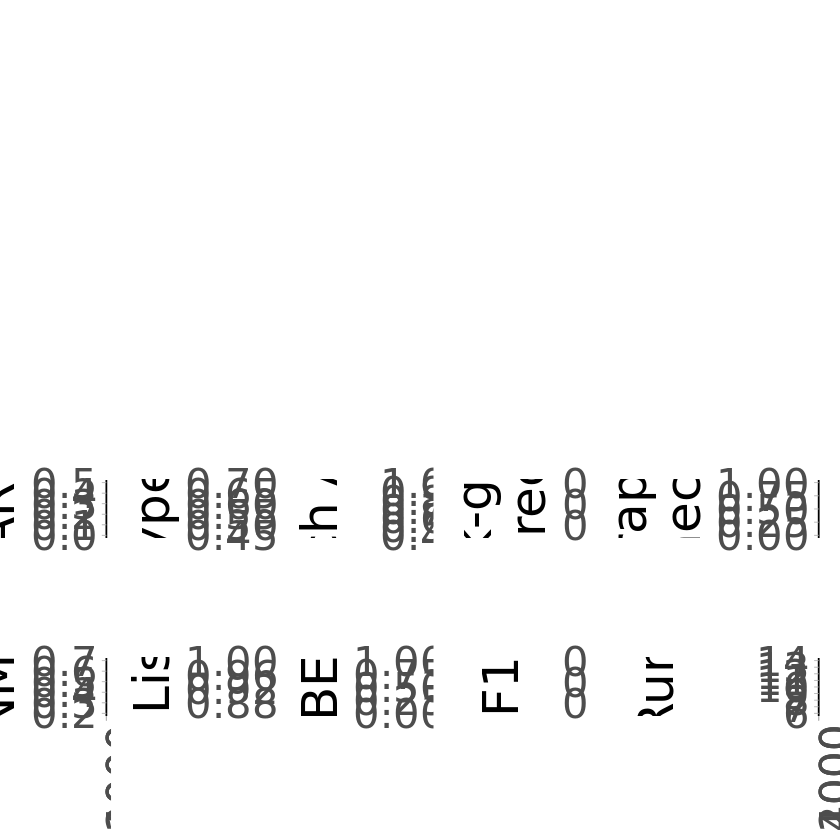

In [12]:
file_name <- "bmmc_single_mod_n_split_metric_summary19_21ct_w_observed.pdf"
folder_path <- "figures/metric_plots/"
dir.create(folder_path)

subplot_idx = list(c("ARI","NMI"),c("Cell type ASW","cLisi"),c("Batch ASW","kBET"),
                   c("Peak-gene \n pair % recovered","F1"),c('log2(Runtime)',"Graph \n connectivity"))

res_plot_3 <- res_plot_2 %>% 
    group_by(metric_name,var,method) %>% 
    # mean after grouping by metric, method, and var
    dplyr::mutate(mean_var = mean(value),
                  sd_var = sd(value)) %>%
    group_by(metric_name,method) %>%
    # mean after grouping by metric and method
    dplyr::mutate(mean_method = mean(value),
                  sd_method = sd(value)) %>%
    mutate(mean_f = ifelse(type=="Unpaired",mean_method,mean_var),
           sd_f = ifelse(type=="Unpaired",0,sd_var))
x_interval = c(1000,2000,4000) 
ylim_list = list(c(0,0.5),c(0.2,0.7),c(0.45,0.7),c(0.85,1),c(0.4,1),c(0,1),c(0.05,0.3),c(0.05,0.3),c(0,1),c(6,14))
nbreaks = list(5,5,5,6,6,5,5,5,5,8)
counter=1
subplots = list()
for(i in 1:length(subplot_idx)){
    print(i)
    subplots[[i]] = res_plot_3 %>%  
            filter(metric_name %in% subplot_idx[[i]]) %>%  
            ggplot(.,aes(x=var,y=mean_f,group=method,col=method_name,shape=type)) + 
            geom_point(size=3) +
            geom_line() +
            geom_errorbar(aes(ymin=mean_f-sd_f, ymax=mean_f+sd_f),
                         position=position_dodge(0.05),alpha=0.2)+
            scale_shape_manual(values = c(15,16,17))+#c(0,1,2))+
            scale_x_continuous(breaks=x_interval) +
            facet_grid(cols = vars(type),rows=vars(metric_name),scales = "free_y", switch="y") +
            theme_light()+
            theme(strip.text.x = element_text(size = 30,angle=90,colour = "black"),
                  strip.text.y = element_text(size = 30,angle=90,colour = "black"),
                  axis.text.x  = element_text(size = 25,angle = 90),axis.text.y = element_text(size = 25),
                  axis.title.x = element_blank(),axis.title.y = element_blank(),
                  strip.background = element_blank(), strip.placement = "outside",
                  panel.spacing.y = unit(5, "lines"),panel.spacing.x = unit(2, "lines"),
                 panel.border=element_blank(), axis.line=element_line())+
    ggh4x::facetted_pos_scales(
        y = list(
            scale_y_continuous(limits = ylim_list[[counter]],n.breaks = nbreaks[[counter]]),
            scale_y_continuous(limits = ylim_list[[counter+1]],n.breaks = nbreaks[[counter+1]])

        )
    )
    counter = counter + 2
    if(plot_ref_accuracy){
        if("F1" %in% subplot_idx[[i]]){
            subplots[[i]] = subplots[[i]] +
                geom_hline(data = truth_df, aes(yintercept = Z),linetype =2,color="red")
        }
    }

}
subplots_no_bdg = lapply(subplots,function(x){x+theme(legend.position = "none")})
pcomb <- grid.arrange(grobs=subplots_no_bdg,nrow=1)


# function to extract legend from plot
get_only_legend <- function(plot) {
  plot_table <- ggplot_gtable(ggplot_build(plot))
  legend_plot <- which(sapply(plot_table$grobs, function(x){x$name}) == "guide-box")
  legend <- plot_table$grobs[[legend_plot]]
  return(legend)
}
                            
# extract legend from plot1 using above function
legend <- get_only_legend(subplots[[1]])   
                                                          
pdf(file.path(folder_path,file_name),width=35,height=15)    
grid.arrange(pcomb, legend, ncol = 2, widths = c(10, 1))
dev.off()

# Sceanrio 2

## PBMC 2000 cells

### Load result

In [ ]:
dir_path = "dataset/multiome_pbmc_10k/nmulti2000_7ct_vdepth_test/"

res_all <- plot_result(dir_path,res_folder_filter = c("results"),runtime_exists=T,prediction_exists=T,metric_file = "ct3_metric.csv")

res_all$log2_runtime <- log2(res_all$runtime)

# add _2 to method name and add type column
multiome_guided_method_list<-c("multivi","seurat4","cobolt")
unpaired_method_list<-c("seurat3_2","rfigr_2","rbindsc_2","rliger_2")
res_plot <- res_all %>% 
    mutate(method_name = ifelse(method %in% multiome_guided_method_list,method,paste0(method,"_2")))%>% 
    # assign method type
    mutate(type = ifelse(method_name %in% unpaired_method_list,"Multiome-guided","Unpaired_multiome_split"))

metric_sel = c("ARI","NMI","ct_aws","clisi","b_saw","kbet","gconn","percent_recovered_50kb","f1",
               "log2_runtime")

table(res_plot$method_name)

method_names = c("MultiVI","Seurat v4", "Cobolt",
                 "Seurat v3","bindSC","FigR", "Liger")
row_order = c("multivi","seurat4","cobolt",
              "seurat3_2","rbindsc_2","rfigr_2","rliger_2")
names(method_names)  = row_order

method_type = c(rep("Multiome-guided",3),rep("Unpaired with \n Multiome-split",4))
names(method_type) <- row_order

title_list = c("ARI","NMI","Cell type ASW","cLisi", "Batch ASW","kBET","Graph \n connectivity", 
               "Peak-gene \n pair % recovered","F1","log2(Runtime)")
names(title_list)=metric_sel


res_plot_2 <- res_plot %>% 
    select(ARI:gconn,percent_recovered_50kb:log2_runtime,method_name,var) %>%
    gather(key = "metric_type",
               value = "value", -method_name,-var,)%>%
    mutate(method = method_name) %>%
    mutate(type=factor(method_type[method],levels = c("Unpaired","Unpaired with \n Multiome-split","Multiome-guided"))) %>% 
    mutate(method_name= factor(method_names[method],levels=unique(method_names))) %>% 
    mutate(metric_name = factor(title_list[metric_type],levels = title_list))




### Summary plot

In [ ]:
file_name <- "pbmc_vdepth_summary19_7ct_fair.pdf"
folder_path <- "figures/metric_plots/"
dir.create(folder_path)

subplot_idx = list(c("ARI","NMI"),c("Cell type ASW","cLisi"),c("Batch ASW","kBET"),
                   c("Peak-gene \n pair % recovered","F1"),c('log2(Runtime)',"Graph \n connectivity"))

res_plot_3 <- res_plot_2 %>% 
    group_by(metric_name,var,method) %>% 
    # mean after grouping by metric, method, and var
    dplyr::mutate(mean_var = mean(value),
                  sd_var = sd(value)) %>%
    group_by(metric_name,method) %>%
    # mean after grouping by metric and method
    dplyr::mutate(mean_method = mean(value),
                  sd_method = sd(value)) %>%
    mutate(mean_f = ifelse(type=="Unpaired",mean_method,mean_var),
           sd_f = ifelse(type=="Unpaired",0,sd_var))
x_interval = unique(res_plot_3$var)

ylim_list = list(c(0.2,1),c(0.4,0.9),c(0.5,0.8),c(0.8,1),c(0.6,1),c(0,1),c(0.25,0.5),c(0.25,0.45),c(0,1),c(6,14))
nbreaks = list(4,5,6,4,4,5,5,4,5,8)
counter=1

subplots = list()
for(i in 1:length(subplot_idx)){
    print(i)
    subplots[[i]] = res_plot_3 %>%  
            filter(metric_name %in% subplot_idx[[i]]) %>%  
            ggplot(.,aes(x=var,y=mean_f,group=method,col=method_name,shape=type)) + 
            geom_point(size=3) +
        #     stat_summary(fun.y=mean, geom="point",aes(col=method_name)) +
            geom_line() +
            geom_errorbar(aes(ymin=mean_f-sd_f, ymax=mean_f+sd_f),
                         position=position_dodge(0.05),alpha=0.2)+
            scale_shape_manual(values = c(15,16,17))+#c(0,1,2))+
            scale_x_continuous(breaks=x_interval) +
            facet_grid(cols = vars(type),rows=vars(metric_name),scales = "free_y", switch="y") +
            theme_light()+
            theme(strip.text.x = element_text(size = 30,angle=90,colour = "black"),
                  strip.text.y = element_text(size = 30,angle=90,colour = "black"),
                  axis.text.x  = element_text(size = 25,angle = 90),axis.text.y = element_text(size = 25),
                  axis.title.x = element_blank(),axis.title.y = element_blank(),
                  strip.background = element_blank(), strip.placement = "outside",
                  panel.spacing.y = unit(5, "lines"),panel.spacing.x = unit(2, "lines"),
                 panel.border=element_blank(), axis.line=element_line())+
    ggh4x::facetted_pos_scales(
        y = list(
            scale_y_continuous(limits = ylim_list[[counter]],n.breaks = nbreaks[[counter]]),
            scale_y_continuous(limits = ylim_list[[counter+1]],n.breaks = nbreaks[[counter+1]])

        )
    )
    counter = counter + 2
}
subplots_no_bdg = lapply(subplots,function(x){x+theme(legend.position = "none")})
pcomb <- grid.arrange(grobs=subplots_no_bdg,nrow=1)


# function to extract legend from plot
get_only_legend <- function(plot) {
  plot_table <- ggplot_gtable(ggplot_build(plot))
  legend_plot <- which(sapply(plot_table$grobs, function(x){x$name}) == "guide-box")
  legend <- plot_table$grobs[[legend_plot]]
  return(legend)
}
                            
# extract legend from plot1 using above function
legend <- get_only_legend(subplots[[1]])   
                                                          
pdf(file.path(folder_path,file_name),width=35,height=15)                 
grid.arrange(pcomb, legend, ncol = 2, widths = c(10, 1))
dev.off()


## BMMC 2000 cells

### Load result

In [ ]:
dir_path = "dataset/bmmc/nmulti2000_21ct_vdepth_test/"

res_all <- plot_result(dir_path,res_folder_filter = c("results"),runtime_exists=T,prediction_exists=T,metric_file = "ct3_metric.csv")

res_all$log2_runtime <- log2(res_all$runtime)

# add _2 to method name and add type column
multiome_guided_method_list<-c("multivi","seurat4","cobolt")
unpaired_method_list<-c("seurat3_2","rfigr_2","rbindsc_2","rliger_2")
res_plot <- res_all %>% 
    mutate(method_name = ifelse(method %in% multiome_guided_method_list,method,paste0(method,"_2")))%>% 
    # assign method type
    mutate(type = ifelse(method_name %in% unpaired_method_list,"Multiome-guided","Unpaired_multiome_split"))

metric_sel = c("ARI","NMI","ct_aws","clisi","b_saw","kbet","gconn","percent_recovered_50kb","f1",
               "log2_runtime")

table(res_plot$method_name)

method_names = c("MultiVI","Seurat v4", "Cobolt",
                 "Seurat v3","bindSC","FigR", "Liger")
row_order = c("multivi","seurat4","cobolt",
              "seurat3_2","rbindsc_2","rfigr_2","rliger_2")
names(method_names)  = row_order

method_type = c(rep("Multiome-guided",3),rep("Unpaired with \n Multiome-split",4))
names(method_type) <- row_order

title_list = c("ARI","NMI","Cell type ASW","cLisi", "Batch ASW","kBET","Graph \n connectivity", 
               "Peak-gene \n pair % recovered","F1","log2(Runtime)")
names(title_list)=metric_sel


res_plot_2 <- res_plot %>% 
    select(ARI:gconn,percent_recovered_50kb:log2_runtime,method_name,var) %>%
    gather(key = "metric_type",
               value = "value", -method_name,-var,)%>%
    mutate(method = method_name) %>%
    mutate(type=factor(method_type[method],levels = c("Unpaired","Unpaired with \n Multiome-split","Multiome-guided"))) %>% 
    mutate(method_name= factor(method_names[method],levels=unique(method_names))) %>% 
    mutate(metric_name = factor(title_list[metric_type],levels = title_list))




### Summary plot

In [ ]:
file_name <- "bmmc_nmulti2000_vdepth_metric_summary19_21ct_fair.pdf"
folder_path <- "figures/metric_plots/"
dir.create(folder_path)

subplot_idx = list(c("ARI","NMI"),c("Cell type ASW","cLisi"),c("Batch ASW","kBET"),
                   c("Peak-gene \n pair % recovered","F1"),c('log2(Runtime)',"Graph \n connectivity"))
# add summarized values: unpaired method - summarize across all var (despite 1000/3000/8000 multiome cells); for others, summarize across repeats
res_plot_3 <- res_plot_2 %>% 
    group_by(metric_name,var,method) %>% 
    # mean after grouping by metric, method, and var
    dplyr::mutate(mean_var = mean(value),
                  sd_var = sd(value)) %>%
    group_by(metric_name,method) %>%
    # mean after grouping by metric and method
    dplyr::mutate(mean_method = mean(value),
                  sd_method = sd(value)) %>%
    mutate(mean_f = ifelse(type=="Unpaired",mean_method,mean_var),
           sd_f = ifelse(type=="Unpaired",0,sd_var))
x_interval = unique(res_plot_3$var)
x_interval = unique(res_plot_3$var)
ylim_list = list(c(0,0.5),c(0.2,0.7),c(0.45,0.7),c(0.85,1),c(0.4,1),c(0,1),c(0.05,0.3),c(0.05,0.3),c(0,1),c(6,14))
nbreaks = list(5,5,5,6,6,5,5,5,5,8)
counter=1

subplots = list()
for(i in 1:length(subplot_idx)){
    print(i)
    subplots[[i]] = res_plot_3 %>%  
            filter(metric_name %in% subplot_idx[[i]]) %>%  
            ggplot(.,aes(x=var,y=mean_f,group=method,col=method_name,shape=type)) + 
            geom_point(size=3) +
            geom_line() +
            geom_errorbar(aes(ymin=mean_f-sd_f, ymax=mean_f+sd_f),
                         position=position_dodge(0.05),alpha=0.2)+
            scale_shape_manual(values = c(15,16,17))+#c(0,1,2))+
            scale_x_continuous(breaks=x_interval) +
            facet_grid(cols = vars(type),rows=vars(metric_name),scales = "free_y", switch="y") +
            theme_light()+
            theme(strip.text.x = element_text(size = 30,angle=90,colour = "black"),
                  strip.text.y = element_text(size = 30,angle=90,colour = "black"),
                  axis.text.x  = element_text(size = 25,angle = 90),axis.text.y = element_text(size = 25),
                  axis.title.x = element_blank(),axis.title.y = element_blank(),
                  strip.background = element_blank(), strip.placement = "outside",
                  panel.spacing.y = unit(5, "lines"),panel.spacing.x = unit(2, "lines"),
                 panel.border=element_blank(), axis.line=element_line())+
    ggh4x::facetted_pos_scales(
        y = list(
            scale_y_continuous(limits = ylim_list[[counter]],n.breaks = nbreaks[[counter]]),
            scale_y_continuous(limits = ylim_list[[counter+1]],n.breaks = nbreaks[[counter+1]])

        )
    )
    counter = counter + 2
}
subplots_no_bdg = lapply(subplots,function(x){x+theme(legend.position = "none")})
pcomb <- grid.arrange(grobs=subplots_no_bdg,nrow=1)


# function to extract legend from plot
get_only_legend <- function(plot) {
  plot_table <- ggplot_gtable(ggplot_build(plot))
  legend_plot <- which(sapply(plot_table$grobs, function(x){x$name}) == "guide-box")
  legend <- plot_table$grobs[[legend_plot]]
  return(legend)
}
                            
# extract legend from plot1 using above function
legend <- get_only_legend(subplots[[1]])   
                                                          
pdf(file.path(folder_path,file_name),width=35,height=15)                 
grid.arrange(pcomb, legend, ncol = 2, widths = c(10, 1))
dev.off()


## BMMC 4000 cells

### Load result

In [ ]:
dir_path = "dataset/bmmc/nmulti4000_21ct_vdepth_test/"

res_all <- plot_result(dir_path,res_folder_filter = c("results"),runtime_exists=T,prediction_exists=T,metric_file = "ct3_metric.csv")

res_all$log2_runtime <- log2(res_all$runtime)

# add _2 to method name and add type column
multiome_guided_method_list<-c("multivi","seurat4","cobolt")
unpaired_method_list<-c("seurat3_2","rfigr_2","rbindsc_2","rliger_2")
res_plot <- res_all %>% 
    mutate(method_name = ifelse(method %in% multiome_guided_method_list,method,paste0(method,"_2")))%>% 
    # assign method type
    mutate(type = ifelse(method_name %in% unpaired_method_list,"Multiome-guided","Unpaired_multiome_split"))

metric_sel = c("ARI","NMI","ct_aws","clisi","b_saw","kbet","gconn","percent_recovered_50kb","f1",
               "log2_runtime")

table(res_plot$method_name)

method_names = c("MultiVI","Seurat v4", "Cobolt",
                 "Seurat v3","bindSC","FigR", "Liger")
row_order = c("multivi","seurat4","cobolt",
              "seurat3_2","rbindsc_2","rfigr_2","rliger_2")
names(method_names)  = row_order

method_type = c(rep("Multiome-guided",3),rep("Unpaired with \n Multiome-split",4))
names(method_type) <- row_order

title_list = c("ARI","NMI","Cell type ASW","cLisi", "Batch ASW","kBET","Graph \n connectivity", 
               "Peak-gene \n pair % recovered","F1","log2(Runtime)")
names(title_list)=metric_sel


res_plot_2 <- res_plot %>% 
    select(ARI:gconn,percent_recovered_50kb:log2_runtime,method_name,var) %>%
    gather(key = "metric_type",
               value = "value", -method_name,-var,)%>%
    mutate(method = method_name) %>%
    mutate(type=factor(method_type[method],levels = c("Unpaired","Unpaired with \n Multiome-split","Multiome-guided"))) %>% 
    mutate(method_name= factor(method_names[method],levels=unique(method_names))) %>% 
    mutate(metric_name = factor(title_list[metric_type],levels = title_list))




### Summary plot

In [ ]:
file_name <- "bmmc_nmulti4000_vdepth_metric_summary19_21ct_fair.pdf"
folder_path <- "figures/metric_plots/"
dir.create(folder_path)

subplot_idx = list(c("ARI","NMI"),c("Cell type ASW","cLisi"),c("Batch ASW","kBET"),
                   c("Peak-gene \n pair % recovered","F1"),c('log2(Runtime)',"Graph \n connectivity"))
# add summarized values: unpaired method - summarize across all var (despite 1000/3000/8000 multiome cells); for others, summarize across repeats
res_plot_3 <- res_plot_2 %>% 
    group_by(metric_name,var,method) %>% 
    # mean after grouping by metric, method, and var
    dplyr::mutate(mean_var = mean(value),
                  sd_var = sd(value)) %>%
    group_by(metric_name,method) %>%
    # mean after grouping by metric and method
    dplyr::mutate(mean_method = mean(value),
                  sd_method = sd(value)) %>%
    mutate(mean_f = ifelse(type=="Unpaired",mean_method,mean_var),
           sd_f = ifelse(type=="Unpaired",0,sd_var))
x_interval = unique(res_plot_3$var)
x_interval = unique(res_plot_3$var)
ylim_list = list(c(0,0.5),c(0.2,0.7),c(0.45,0.7),c(0.85,1),c(0.4,1),c(0,1),c(0.05,0.3),c(0.05,0.3),c(0,1),c(6,14))
nbreaks = list(5,5,5,6,6,5,5,5,5,8)
counter=1

subplots = list()
for(i in 1:length(subplot_idx)){
    print(i)
    subplots[[i]] = res_plot_3 %>%  
            filter(metric_name %in% subplot_idx[[i]]) %>%  
            ggplot(.,aes(x=var,y=mean_f,group=method,col=method_name,shape=type)) + 
            geom_point(size=3) +
            geom_line() +
            geom_errorbar(aes(ymin=mean_f-sd_f, ymax=mean_f+sd_f),
                         position=position_dodge(0.05),alpha=0.2)+
            scale_shape_manual(values = c(15,16,17))+#c(0,1,2))+
            scale_x_continuous(breaks=x_interval) +
            facet_grid(cols = vars(type),rows=vars(metric_name),scales = "free_y", switch="y") +
            theme_light()+
            theme(strip.text.x = element_text(size = 30,angle=90,colour = "black"),
                  strip.text.y = element_text(size = 30,angle=90,colour = "black"),
                  axis.text.x  = element_text(size = 25,angle = 90),axis.text.y = element_text(size = 25),
                  axis.title.x = element_blank(),axis.title.y = element_blank(),
                  strip.background = element_blank(), strip.placement = "outside",
                  panel.spacing.y = unit(5, "lines"),panel.spacing.x = unit(2, "lines"),
                 panel.border=element_blank(), axis.line=element_line())+
    ggh4x::facetted_pos_scales(
        y = list(
            scale_y_continuous(limits = ylim_list[[counter]],n.breaks = nbreaks[[counter]]),
            scale_y_continuous(limits = ylim_list[[counter+1]],n.breaks = nbreaks[[counter+1]])

        )
    )
    counter = counter + 2
}
subplots_no_bdg = lapply(subplots,function(x){x+theme(legend.position = "none")})
pcomb <- grid.arrange(grobs=subplots_no_bdg,nrow=1)


# function to extract legend from plot
get_only_legend <- function(plot) {
  plot_table <- ggplot_gtable(ggplot_build(plot))
  legend_plot <- which(sapply(plot_table$grobs, function(x){x$name}) == "guide-box")
  legend <- plot_table$grobs[[legend_plot]]
  return(legend)
}
                            
# extract legend from plot1 using above function
legend <- get_only_legend(subplots[[1]])   
                                                          
pdf(file.path(folder_path,file_name),width=35,height=15)                 
grid.arrange(pcomb, legend, ncol = 2, widths = c(10, 1))
dev.off()


## BMMC Increasing number of cells; 100% depth

### Load result

In [20]:
# read in metric in ct3_metric.csv
dir_path = "dataset/bmmc/bmmc_vcells_intervals/"

res_all <- plot_result(dir_path,res_folder_filter = c("results"),runtime_exists=T,prediction_exists=T,metric_file = "ct3_metric.csv")

res_all$log2_runtime <- log2(res_all$runtime)

# add _2 to method name and add type column
multiome_guided_method_list<-c("multivi","seurat4","cobolt")
unpaired_method_list<-c("seurat3_2","rfigr_2","rbindsc_2","rliger_2")
res_plot <- res_all %>% 
    mutate(method_name = ifelse(method %in% multiome_guided_method_list,method,paste0(method,"_2")))%>% 
    # assign method type
    mutate(type = ifelse(method_name %in% unpaired_method_list,"Multiome-guided","Unpaired_multiome_split"))

metric_sel = c("ARI","NMI","ct_aws","clisi","b_saw","kbet","gconn","percent_recovered_50kb","f1",
               "log2_runtime")

table(res_plot$method_name)

method_names = c("Seurat v3","Seurat v4")
row_order = c("seurat3_2","seurat4")
names(method_names)  = row_order

method_type = c(rep("Unpaired with \n Multiome-split",1),rep("Multiome-guided",1))
names(method_type) <- row_order

title_list = c("ARI","NMI","Cell type ASW","cLisi", "Batch ASW","kBET","Graph \n connectivity", 
               "Peak-gene \n pair % recovered","F1","log2(Runtime)")
names(title_list)=metric_sel


res_plot_2 <- res_plot %>% 
    select(ARI:gconn,percent_recovered_50kb:log2_runtime,method_name,var) %>%
    gather(key = "metric_type",
               value = "value", -method_name,-var,)%>%
    mutate(method = method_name) %>%
    mutate(type=factor(method_type[method],levels = c("Unpaired","Unpaired with \n Multiome-split","Multiome-guided"))) %>% 
    mutate(method_name= factor(method_names[method],levels=unique(method_names))) %>% 
    mutate(metric_name = factor(title_list[metric_type],levels = title_list))




Joining, by = c("orig", "var", "rep", "method", "out")
Joining, by = c("orig", "var", "rep", "method", "out")



seurat3_2   seurat4 
       50        50 

### Summary plot

Warning message in dir.create(folder_path):
“'figures/metric_plots' already exists”


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5


png 
  2

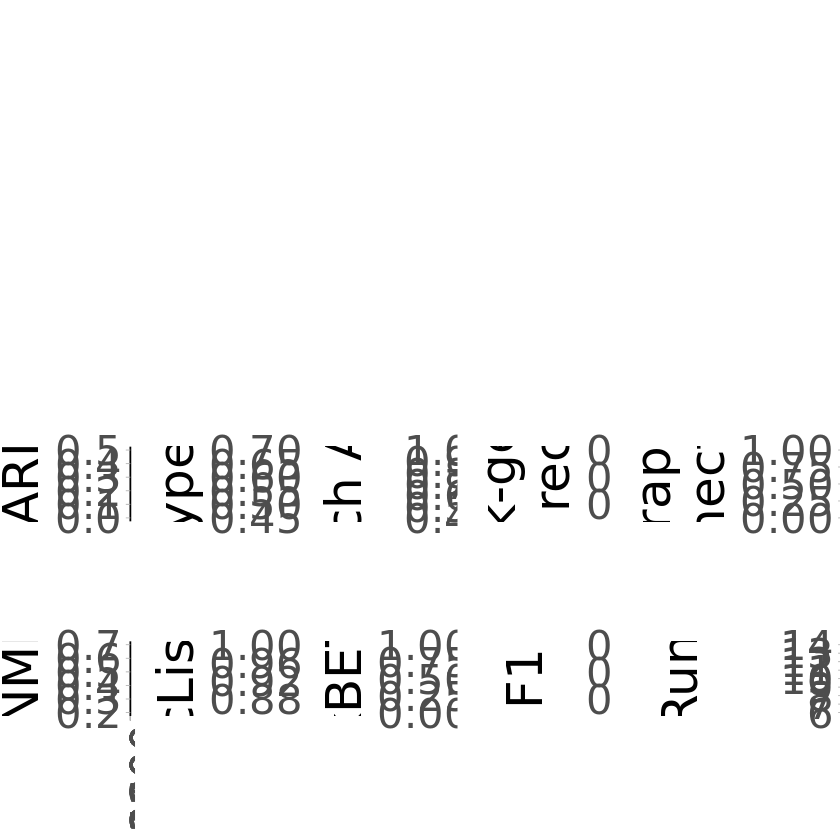

In [21]:
file_name <- "bmmc_nmulti4000_vdepth_10interv_summary19_21ct_fair.pdf"
folder_path <- "figures/metric_plots/"
dir.create(folder_path)

subplot_idx = list(c("ARI","NMI"),c("Cell type ASW","cLisi"),c("Batch ASW","kBET"),
                   c("Peak-gene \n pair % recovered","F1"),c('log2(Runtime)',"Graph \n connectivity"))

res_plot_3 <- res_plot_2 %>% 
    group_by(metric_name,var,method) %>% 
    # mean after grouping by metric, method, and var
    dplyr::mutate(mean_var = mean(value),
                  sd_var = sd(value)) %>%
    group_by(metric_name,method) %>%
    # mean after grouping by metric and method
    dplyr::mutate(mean_method = mean(value),
                  sd_method = sd(value)) %>%
    mutate(mean_f = ifelse(type=="Unpaired",mean_method,mean_var),
           sd_f = ifelse(type=="Unpaired",0,sd_var))
x_interval = unique(res_plot_3$var)

method_names7 = c("MultiVI","Seurat v4", "Cobolt","Seurat v3","bindSC","FigR", "Liger")
hex <- c(scales::hue_pal()(length(method_names7)),"#4169e1")
names(hex)<- c(method_names7,"Seurat v4 integrate")

ylim_list = list(c(0,0.5),c(0.2,0.7),c(0.45,0.7),c(0.85,1),c(0.4,1),c(0,1),c(0.05,0.3),c(0.05,0.3),c(0,1),c(6,14))
nbreaks = list(5,5,5,6,6,5,5,5,5,8)
counter=1
subplots = list()
for(i in 1:length(subplot_idx)){
    print(i)
    subplots[[i]] = res_plot_3 %>%  
            filter(metric_name %in% subplot_idx[[i]]) %>%  
            ggplot(.,aes(x=var,y=mean_f,group=method,col=method_name,shape=type)) + 
            geom_point(size=3) +
            geom_line() +
            geom_errorbar(aes(ymin=mean_f-sd_f, ymax=mean_f+sd_f),
                         position=position_dodge(0.05),alpha=0.2)+
            scale_shape_manual(values = c(15,16,17))+#c(0,1,2))+
            scale_x_continuous(breaks=x_interval) +
            scale_color_manual(values= hex,labels=names(hex)) +
            facet_grid(cols = vars(type),rows=vars(metric_name),scales = "free_y", switch="y") +
            theme_light()+
            theme(strip.text.x = element_text(size = 30,angle=90,colour = "black"),
                  strip.text.y = element_text(size = 30,angle=90,colour = "black"),
                  axis.text.x  = element_text(size = 25,angle = 90),axis.text.y = element_text(size = 25),
                  axis.title.x = element_blank(),axis.title.y = element_blank(),
                  strip.background = element_blank(), strip.placement = "outside",
                  panel.spacing.y = unit(5, "lines"),panel.spacing.x = unit(2, "lines"),
                 panel.border=element_blank(), axis.line=element_line())+
    ggh4x::facetted_pos_scales(
        y = list(
            scale_y_continuous(limits = ylim_list[[counter]],n.breaks = nbreaks[[counter]]),
            scale_y_continuous(limits = ylim_list[[counter+1]],n.breaks = nbreaks[[counter+1]])

        )
    )
    counter = counter + 2
}
subplots_no_bdg = lapply(subplots,function(x){x+theme(legend.position = "none")})
pcomb <- grid.arrange(grobs=subplots_no_bdg,nrow=1)


# function to extract legend from plot
get_only_legend <- function(plot) {
  plot_table <- ggplot_gtable(ggplot_build(plot))
  legend_plot <- which(sapply(plot_table$grobs, function(x){x$name}) == "guide-box")
  legend <- plot_table$grobs[[legend_plot]]
  return(legend)
}
                            
# extract legend from plot1 using above function
legend <- get_only_legend(subplots[[1]])   
                                                          
pdf(file.path(folder_path,file_name),width=35,height=15)              
grid.arrange(pcomb, legend, ncol = 2, widths = c(10, 1))
dev.off()


## BMMC Increasing depth; 4000 cells

### Load result

In [22]:
dir_path = "dataset/bmmc/bmmc_vdepth_intervals/"

res_all <- plot_result(dir_path,res_folder_filter = c("results"),runtime_exists=T,prediction_exists=T,metric_file = "ct3_metric.csv")

res_all$log2_runtime <- log2(res_all$runtime)

# add _2 to method name and add type column
multiome_guided_method_list<-c("multivi","seurat4","cobolt")
unpaired_method_list<-c("seurat3_2","rfigr_2","rbindsc_2","rliger_2")
res_plot <- res_all %>% 
    mutate(method_name = ifelse(method %in% multiome_guided_method_list,method,paste0(method,"_2")))%>% 
    # assign method type
    mutate(type = ifelse(method_name %in% unpaired_method_list,"Multiome-guided","Unpaired_multiome_split"))

metric_sel = c("ARI","NMI","ct_aws","clisi","b_saw","kbet","gconn","percent_recovered_50kb","f1",
               "log2_runtime")

table(res_plot$method_name)

method_names = c("MultiVI","Seurat v4", "Cobolt",
                 "Seurat v3","bindSC","FigR", "Liger")
row_order = c("multivi","seurat4","cobolt",
              "seurat3_2","rbindsc_2","rfigr_2","rliger_2")
names(method_names)  = row_order

method_type = c(rep("Multiome-guided",3),rep("Unpaired with \n Multiome-split",4))
names(method_type) <- row_order

title_list = c("ARI","NMI","Cell type ASW","cLisi", "Batch ASW","kBET","Graph \n connectivity", 
               "Peak-gene \n pair % recovered","F1","log2(Runtime)")
names(title_list)=metric_sel


res_plot_2 <- res_plot %>% 
    select(ARI:gconn,percent_recovered_50kb:log2_runtime,method_name,var) %>%
    gather(key = "metric_type",
               value = "value", -method_name,-var,)%>%
    mutate(method = method_name) %>%
    mutate(type=factor(method_type[method],levels = c("Unpaired","Unpaired with \n Multiome-split","Multiome-guided"))) %>% 
    mutate(method_name= factor(method_names[method],levels=unique(method_names))) %>% 
    mutate(metric_name = factor(title_list[metric_type],levels = title_list))




Joining, by = c("orig", "var", "rep", "method", "out")
Joining, by = c("orig", "var", "rep", "method", "out")



seurat3_2   seurat4 
       50        50 

### Summary plot

Warning message in dir.create(folder_path):
“'figures/metric_plots' already exists”


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5


png 
  2

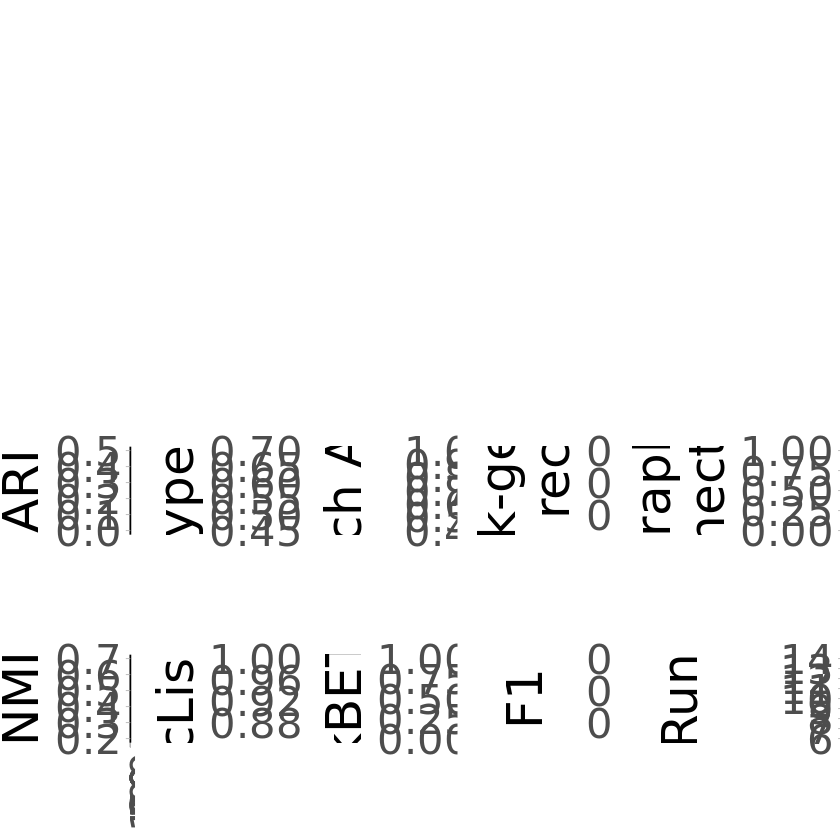

In [23]:
file_name <- "bmmc_nmulti4000_vdepth_10interv_summary19_21ct_fair.pdf"
folder_path <- "figures/metric_plots/"
dir.create(folder_path)

subplot_idx = list(c("ARI","NMI"),c("Cell type ASW","cLisi"),c("Batch ASW","kBET"),
                   c("Peak-gene \n pair % recovered","F1"),c('log2(Runtime)',"Graph \n connectivity"))

res_plot_3 <- res_plot_2 %>% 
    group_by(metric_name,var,method) %>% 
    # mean after grouping by metric, method, and var
    dplyr::mutate(mean_var = mean(value),
                  sd_var = sd(value)) %>%
    group_by(metric_name,method) %>%
    # mean after grouping by metric and method
    dplyr::mutate(mean_method = mean(value),
                  sd_method = sd(value)) %>%
    mutate(mean_f = ifelse(type=="Unpaired",mean_method,mean_var),
           sd_f = ifelse(type=="Unpaired",0,sd_var))
x_interval = unique(res_plot_3$var)

method_names7 = c("MultiVI","Seurat v4", "Cobolt","Seurat v3","bindSC","FigR", "Liger")
hex <- c(scales::hue_pal()(length(method_names7)),"#4169e1")
names(hex)<- c(method_names7,"Seurat v4 integrate")

ylim_list = list(c(0,0.5),c(0.2,0.7),c(0.45,0.7),c(0.85,1),c(0.4,1),c(0,1),c(0.05,0.3),c(0.05,0.3),c(0,1),c(6,14))
nbreaks = list(5,5,5,6,6,5,5,5,5,8)
counter=1
subplots = list()
for(i in 1:length(subplot_idx)){
    print(i)
    subplots[[i]] = res_plot_3 %>%  
            filter(metric_name %in% subplot_idx[[i]]) %>%  
            ggplot(.,aes(x=var,y=mean_f,group=method,col=method_name,shape=type)) + 
            geom_point(size=3) +
            geom_line() +
            geom_errorbar(aes(ymin=mean_f-sd_f, ymax=mean_f+sd_f),
                         position=position_dodge(0.05),alpha=0.2)+
            scale_shape_manual(values = c(15,16,17))+#c(0,1,2))+
            scale_x_continuous(breaks=x_interval) +
            scale_color_manual(values= hex,labels=names(hex)) +
            facet_grid(cols = vars(type),rows=vars(metric_name),scales = "free_y", switch="y") +
            theme_light()+
            theme(strip.text.x = element_text(size = 30,angle=90,colour = "black"),
                  strip.text.y = element_text(size = 30,angle=90,colour = "black"),
                  axis.text.x  = element_text(size = 25,angle = 90),axis.text.y = element_text(size = 25),
                  axis.title.x = element_blank(),axis.title.y = element_blank(),
                  strip.background = element_blank(), strip.placement = "outside",
                  panel.spacing.y = unit(5, "lines"),panel.spacing.x = unit(2, "lines"),
                 panel.border=element_blank(), axis.line=element_line())+
    ggh4x::facetted_pos_scales(
        y = list(
            scale_y_continuous(limits = ylim_list[[counter]],n.breaks = nbreaks[[counter]]),
            scale_y_continuous(limits = ylim_list[[counter+1]],n.breaks = nbreaks[[counter+1]])

        )
    )
    counter = counter + 2
}
subplots_no_bdg = lapply(subplots,function(x){x+theme(legend.position = "none")})
pcomb <- grid.arrange(grobs=subplots_no_bdg,nrow=1)


# function to extract legend from plot
get_only_legend <- function(plot) {
  plot_table <- ggplot_gtable(ggplot_build(plot))
  legend_plot <- which(sapply(plot_table$grobs, function(x){x$name}) == "guide-box")
  legend <- plot_table$grobs[[legend_plot]]
  return(legend)
}
                            
# extract legend from plot1 using above function
legend <- get_only_legend(subplots[[1]])   
                                                          
#pdf(file.path(folder_path,file_name),width=35,height=15) 
pdf("tmp_fig4.pdf",width=35,height=15) 
grid.arrange(pcomb, legend, ncol = 2, widths = c(10, 1))
dev.off()


# Sceanrio 3

## Technical batch effect

### Load result

In [27]:
# read in metric in ct3wbatch_metric.csv, then ct3wbatch_metric_sample_batch.csv, and then combine
dir_path = "dataset/bmmc/bmmc_technical_batch_test/"
folder_path <- "figures/metric_plots/"
dir.create(folder_path)

res_all <- plot_result(dir_path,res_folder_filter = c("results"),runtime_exists=T,prediction_exists=T,metric_file = "ct3_metric.csv")

res_all_batch <- plot_result(dir_path,res_folder_filter = c("results"),runtime_exists=T,prediction_exists=T,metric_file = "ct3_metric_sample_batch.csv")

res_all_comb <- left_join(res_all,res_all_batch[2:10])
res_all_comb$log2_runtime <- log2(res_all_comb$runtime)

table(is.na(res_all_comb$batch_b_saw))

# add _2 to method name and add type column
multiome_guided_method_list<-c("multivi","seurat4","cobolt")
unpaired_method_list<-c("seurat3_2","rfigr_2","rbindsc_2","rliger_2")
res_plot <- res_all_comb %>% 
    filter(var %in% c(1000,3000,5000)) %>% 
    mutate(method_name = ifelse(method %in% multiome_guided_method_list,method,paste0(method,"_2")))%>% 
    # assign method type
    mutate(type = ifelse(method_name %in% unpaired_method_list,"Multiome-guided","Unpaired_multiome_split"))

metric_sel = c("ARI","NMI","ct_aws","clisi","b_saw","kbet","gconn","batch_b_saw","batch_kbet",
               "log2_runtime")

res_plot = res_plot %>% filter(ct_ref =="ct3_metric.csv")
table(res_plot$method_name)

method_names = c("MultiVI","Seurat v4", "Cobolt",
                 "Seurat v3","bindSC","FigR", "Liger")
row_order = c("multivi","seurat4","cobolt",
              "seurat3_2","rbindsc_2","rfigr_2","rliger_2")
names(method_names)  = row_order

method_type = c(rep("Multiome-guided",3),rep("Unpaired with \n Multiome-split",4))
names(method_type) <- row_order

title_list = c("ARI","NMI","Cell type ASW","cLisi", "Batch ASW","kBET","Graph \n connectivity", 
               "Site ASW","Site kBET","log2(Runtime)")
names(title_list)=metric_sel


res_plot_2 <- res_plot %>% 
    select(ARI:gconn,percent_recovered_50kb:log2_runtime,method_name,var) %>%
    gather(key = "metric_type",
               value = "value", -method_name,-var,)%>%
    mutate(method = method_name) %>%
    mutate(type=factor(method_type[method],levels = c("Unpaired","Unpaired with \n Multiome-split","Multiome-guided"))) %>% 
    mutate(method_name= factor(method_names[method],levels=unique(method_names))) %>% 
    mutate(metric_name = factor(title_list[metric_type],levels = title_list))





   cobolt   multivi rbindsc_2   rfigr_2  rliger_2 seurat3_2   seurat4 
       15        15        15        15        15        15        15 

### Summary plot

Warning message in dir.create(folder_path):
“'figures/metric_plots' already exists”


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5


png 
  2

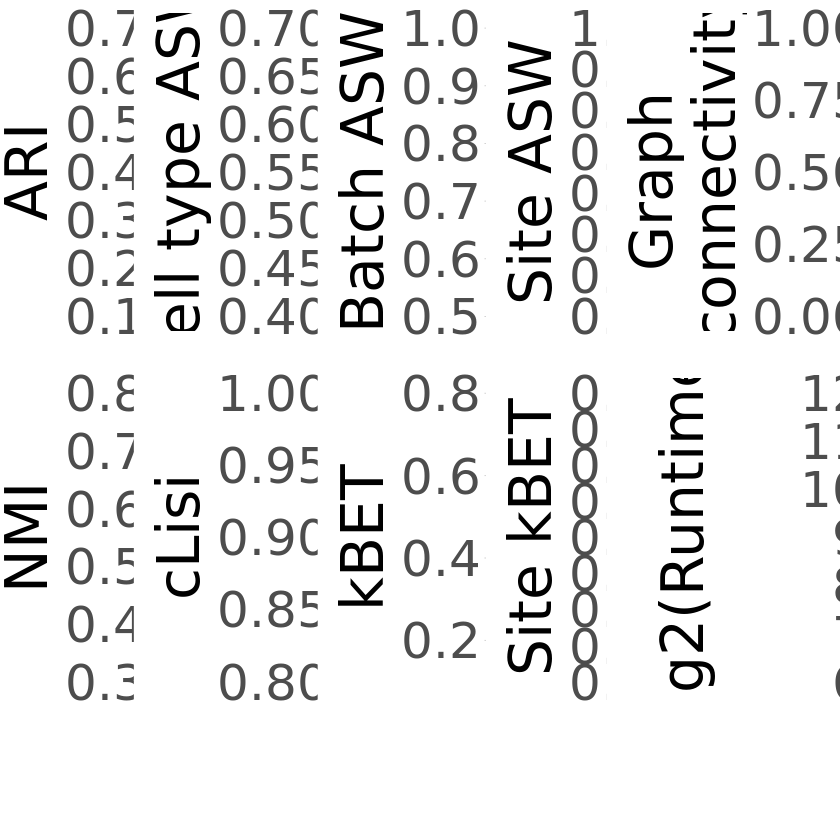

In [28]:
file_name <- "summary_bmmc_technical_batch_test.pdf"
folder_path <- "figures/metric_plots/"
dir.create(folder_path)

subplot_idx = list(c("ARI","NMI"),
                   c("Cell type ASW","cLisi"),
                   c("Batch ASW","kBET"),
                   c("Site ASW","Site kBET"),
                   c("Graph \n connectivity",'log2(Runtime)'))

ylim_list = list(c(0.1,0.7),c(0.3,0.8),
                 c(0.4,0.7), c(0.8,1.0),
                 c(0.5,1),c(0.1,0.8),
                 c(0.2,1),c(0.1,1),
                 c(0,1),c(6,12))
nbreaks = list(6,5,
               6,5,
               5,6,
               8,9,
               5,6)

res_plot_3 <- res_plot_2 %>% 
    group_by(metric_name,var,method) %>% 
    # mean after grouping by metric, method, and var
    dplyr::mutate(mean_var = mean(value),
                  sd_var = sd(value)) %>%
    group_by(metric_name,method) %>%
    # mean after grouping by metric and method
    dplyr::mutate(mean_method = mean(value),
                  sd_method = sd(value)) %>%
    mutate(mean_f = ifelse(type=="Unpaired",mean_method,mean_var),
           sd_f = ifelse(type=="Unpaired",0,sd_var))
x_interval = unique(res_plot_3$var)
subplots = list()
counter = 1
for(i in 1:length(subplot_idx)){
    print(i)
    subplots[[i]] = res_plot_3 %>%  
            filter(metric_name %in% subplot_idx[[i]]) %>%  
            ggplot(.,aes(x=var,y=mean_f,group=method,col=method_name,shape=type)) + 
            geom_point(size=3) +
            geom_line() +
            geom_errorbar(aes(ymin=mean_f-sd_f, ymax=mean_f+sd_f),
                         position=position_dodge(0.05),alpha=0.2)+
            scale_shape_manual(values = c(15,16,17))+#c(0,1,2))+
            scale_x_continuous(breaks=x_interval) +
            facet_grid(cols = vars(type),rows=vars(metric_name),scales = "free_y", switch="y") +
            theme_light()+
            theme(#strip.text.x = element_text(size = 35,angle=90,colour = "black"),
                  strip.text.x = element_blank(),
                  strip.text.y = element_text(size = 35,angle=90,colour = "black"),
                  axis.text.x  = element_text(size = 30,angle = 90),axis.text.y = element_text(size = 30),
                  axis.title.x = element_blank(),axis.title.y = element_blank(),
                  strip.background = element_blank(), strip.placement = "outside",
                  panel.spacing.y = unit(2, "lines"),panel.spacing.x = unit(1, "lines"),
                 panel.border=element_blank(), axis.line=element_line())+
    ggh4x::facetted_pos_scales(
        y = list(
            scale_y_continuous(limits = ylim_list[[counter]],n.breaks = nbreaks[[counter]]),
            scale_y_continuous(limits = ylim_list[[counter+1]],n.breaks = nbreaks[[counter+1]])

        )
    )
    counter = counter + 2
}
subplots_no_bdg = lapply(subplots,function(x){x+theme(legend.position = "none")})
pcomb <- grid.arrange(grobs=subplots_no_bdg,nrow=1)


# function to extract legend from plot
get_only_legend <- function(plot) {
  plot_table <- ggplot_gtable(ggplot_build(plot))
  legend_plot <- which(sapply(plot_table$grobs, function(x){x$name}) == "guide-box")
  legend <- plot_table$grobs[[legend_plot]]
  return(legend)
}
                            
# extract legend from plot1 using above function
legend <- get_only_legend(subplots[[1]])   
                                                          
pdf(file.path(folder_path,file_name),width=30,height=10)     
grid.arrange(pcomb, legend, ncol = 2, widths = c(10, 1))
dev.off()


## Biological batch effect

### Load result

In [ ]:
# read in metric in ct3wbatch_metric.csv, then ct3wbatch_metric_sample_batch.csv, and then combine
dir_path = "dataset/bmmc/bmmc_biological_batch_test/"
folder_path <- "figures/metric_plots/"
dir.create(folder_path)

res_all <- plot_result(dir_path,res_folder_filter = c("results"),runtime_exists=T,prediction_exists=T,metric_file = "ct3_metric.csv")

res_all_batch <- plot_result(dir_path,res_folder_filter = c("results"),runtime_exists=T,prediction_exists=T,metric_file = "ct3_metric_sample_batch.csv")

res_all_comb <- left_join(res_all,res_all_batch[2:10])
res_all_comb$log2_runtime <- log2(res_all_comb$runtime)

table(is.na(res_all_comb$batch_b_saw))

# add _2 to method name and add type column
multiome_guided_method_list<-c("multivi","seurat4","cobolt")
unpaired_method_list<-c("seurat3_2","rfigr_2","rbindsc_2","rliger_2")
res_plot <- res_all_comb %>% 
    filter(var %in% c(1000,3000,5000)) %>% 
    mutate(method_name = ifelse(method %in% multiome_guided_method_list,method,paste0(method,"_2")))%>% 
    # assign method type
    mutate(type = ifelse(method_name %in% unpaired_method_list,"Multiome-guided","Unpaired_multiome_split"))

metric_sel = c("ARI","NMI","ct_aws","clisi","b_saw","kbet","gconn","batch_b_saw","batch_kbet",
               "log2_runtime")

res_plot = res_plot %>% filter(ct_ref =="ct3_metric.csv")
table(res_plot$method_name)

method_names = c("MultiVI","Seurat v4", "Cobolt",
                 "Seurat v3","bindSC","FigR", "Liger")
row_order = c("multivi","seurat4","cobolt",
              "seurat3_2","rbindsc_2","rfigr_2","rliger_2")
names(method_names)  = row_order

method_type = c(rep("Multiome-guided",3),rep("Unpaired with \n Multiome-split",4))
names(method_type) <- row_order

title_list = c("ARI","NMI","Cell type ASW","cLisi", "Batch ASW","kBET","Graph \n connectivity", 
               "Site ASW","Site kBET","log2(Runtime)")
names(title_list)=metric_sel


res_plot_2 <- res_plot %>% 
    select(ARI:gconn,percent_recovered_50kb:log2_runtime,method_name,var) %>%
    gather(key = "metric_type",
               value = "value", -method_name,-var,)%>%
    mutate(method = method_name) %>%
    mutate(type=factor(method_type[method],levels = c("Unpaired","Unpaired with \n Multiome-split","Multiome-guided"))) %>% 
    mutate(method_name= factor(method_names[method],levels=unique(method_names))) %>% 
    mutate(metric_name = factor(title_list[metric_type],levels = title_list))




### Summary plot

In [ ]:
file_name <- "summary_bmmc_biological_batch_test.pdf"
folder_path <- "figures/metric_plots/"
dir.create(folder_path)

subplot_idx = list(c("ARI","NMI"),
                   c("Cell type ASW","cLisi"),
                   c("Batch ASW","kBET"),
                   c("Donor ASW","Donor kBET"),
                   c("Graph \n connectivity",'log2(Runtime)'))

ylim_list = list(c(0.1,0.7),c(0.3,0.8),
                 c(0.4,0.7), c(0.8,1.0),
                 c(0.5,1),c(0.1,0.8),
                 c(0.2,1),c(0.1,1),
                 c(0,1),c(6,12))
nbreaks = list(6,5,
               6,5,
               5,6,
               8,9,
               5,6)

res_plot_3 <- res_plot_2 %>% 
    group_by(metric_name,var,method) %>% 
    # mean after grouping by metric, method, and var
    dplyr::mutate(mean_var = mean(value),
                  sd_var = sd(value)) %>%
    group_by(metric_name,method) %>%
    # mean after grouping by metric and method
    dplyr::mutate(mean_method = mean(value),
                  sd_method = sd(value)) %>%
    mutate(mean_f = ifelse(type=="Unpaired",mean_method,mean_var),
           sd_f = ifelse(type=="Unpaired",0,sd_var))
x_interval = unique(res_plot_3$var)
subplots = list()
counter = 1
for(i in 1:length(subplot_idx)){
    print(i)
    subplots[[i]] = res_plot_3 %>%  
            filter(metric_name %in% subplot_idx[[i]]) %>%  
            ggplot(.,aes(x=var,y=mean_f,group=method,col=method_name,shape=type)) + 
            geom_point(size=3) +
            geom_line() +
            geom_errorbar(aes(ymin=mean_f-sd_f, ymax=mean_f+sd_f),
                         position=position_dodge(0.05),alpha=0.2)+
            scale_shape_manual(values = c(15,16,17))+#c(0,1,2))+
            scale_x_continuous(breaks=x_interval) +
            facet_grid(cols = vars(type),rows=vars(metric_name),scales = "free_y", switch="y") +
            theme_light()+
            theme(#strip.text.x = element_text(size = 35,angle=90,colour = "black"),
                  strip.text.x = element_blank(),
                  strip.text.y = element_text(size = 35,angle=90,colour = "black"),
                  axis.text.x  = element_text(size = 30,angle = 90),axis.text.y = element_text(size = 30),
                  axis.title.x = element_blank(),axis.title.y = element_blank(),
                  strip.background = element_blank(), strip.placement = "outside",
                  panel.spacing.y = unit(2, "lines"),panel.spacing.x = unit(1, "lines"),
                 panel.border=element_blank(), axis.line=element_line())+
    ggh4x::facetted_pos_scales(
        y = list(
            scale_y_continuous(limits = ylim_list[[counter]],n.breaks = nbreaks[[counter]]),
            scale_y_continuous(limits = ylim_list[[counter+1]],n.breaks = nbreaks[[counter+1]])

        )
    )
    counter = counter + 2
}
subplots_no_bdg = lapply(subplots,function(x){x+theme(legend.position = "none")})
pcomb <- grid.arrange(grobs=subplots_no_bdg,nrow=1)


# function to extract legend from plot
get_only_legend <- function(plot) {
  plot_table <- ggplot_gtable(ggplot_build(plot))
  legend_plot <- which(sapply(plot_table$grobs, function(x){x$name}) == "guide-box")
  legend <- plot_table$grobs[[legend_plot]]
  return(legend)
}
                            
# extract legend from plot1 using above function
legend <- get_only_legend(subplots[[1]])   
                                                          
pdf(file.path(folder_path,file_name),width=30,height=10)     
grid.arrange(pcomb, legend, ncol = 2, widths = c(10, 1))
dev.off()


## Complex test #1

### Load result

In [ ]:
# read in metric in ct3wbatch_metric.csv, then ct3wbatch_metric_sample_batch.csv, and then combine
dir_path = "dataset/bmmc/bmmc_complex1_test/"
folder_path <- "figures/metric_plots/"
dir.create(folder_path)

res_all <- plot_result(dir_path,res_folder_filter = c("results"),runtime_exists=T,prediction_exists=T,metric_file = "ct3_metric.csv")
table(res_all$method)
table(res_all$out)


res_all_batch <- plot_result(dir_path,res_folder_filter = c("results"),runtime_exists=T,prediction_exists=T,metric_file = "ct3_metric_sample_batch.csv")
table(res_all_batch$method)
table(res_all_batch$out)

res_all_comb <- left_join(res_all,res_all_batch[2:10])
res_all_comb$log2_runtime <- log2(res_all_comb$runtime)

table(is.na(res_all_comb$batch_b_saw))

# add _2 to method name and add type column
multiome_guided_method_list<-c("multivi","seurat4","cobolt","seurat4int")
unpaired_method_list<-c("seurat3_2","rfigr_2","rbindsc_2","rliger_2")
res_plot <- res_all_comb %>% 
    mutate(method_name = ifelse(method %in% multiome_guided_method_list,method,paste0(method,"_2")))%>% 
    # assign method type
    mutate(type = ifelse(method_name %in% unpaired_method_list,"Multiome-guided","Unpaired_multiome_split"))

metric_sel = c("ARI","NMI","ct_aws","clisi","b_saw","kbet","gconn","batch_b_saw","batch_kbet",
               "log2_runtime")

res_plot = res_plot %>% filter(ct_ref =="ct3_metric.csv")
table(res_plot$method_name)

method_names = c("MultiVI","Seurat v4", "Cobolt","Seurat v4 integrate",
                 "Seurat v3","bindSC","FigR", "Liger")
row_order = c("multivi","seurat4","cobolt","seurat4int",
              "seurat3_2","rbindsc_2","rfigr_2","rliger_2")

names(method_names)  = row_order

method_type = c(rep("Multiome-guided",4),rep("Unpaired with \n Multiome-split",4))

names(method_type) <- row_order

title_list = c("ARI","NMI","Cell type ASW","cLisi", "Batch ASW","kBET","Graph \n connectivity", 
               "Donor ASW","Donor kBET","log2(Runtime)")
names(title_list)=metric_sel


res_plot_2 <- res_plot %>% 
    select(ARI:gconn,percent_recovered_50kb:log2_runtime,method_name,var) %>%
    gather(key = "metric_type",
               value = "value", -method_name,-var,)%>%
    mutate(method = method_name) %>%
    mutate(type=factor(method_type[method],levels = c("Unpaired","Unpaired with \n Multiome-split","Multiome-guided"))) %>% 
    mutate(method_name= factor(method_names[method],levels=unique(method_names))) %>% 
    mutate(metric_name = factor(title_list[metric_type],levels = title_list))





### Summary plot

In [ ]:
# color palette for methods 
method_names7 = c("MultiVI","Seurat v4", "Cobolt","Seurat v3","bindSC","FigR", "Liger")
hex <- c(scales::hue_pal()(length(method_names7)),"#4169e1")
names(hex)<- c(method_names7,"Seurat v4 integrate")

file_name <- "summary_bmmc_complex1_test.pdf"
folder_path <- "figures/metric_plots/"
dir.create(folder_path)

subplot_idx = list(c("ARI","NMI"),
                   c("Cell type ASW","cLisi"),
                   c("Batch ASW","kBET"),
                   c("Donor ASW","Donor kBET"),
                   c("Graph \n connectivity",'log2(Runtime)'))

ylim_list = list(c(0.1,0.7),c(0.3,0.8),
                 c(0.4,0.7), c(0.8,1.0),
                 c(0.5,1),c(0.1,0.8),
                 c(0.2,1),c(0.1,1),
                 c(0,1),c(6,12))
nbreaks = list(6,5,
               6,5,
               5,6,
               8,9,
               5,6)

res_plot_3 <- res_plot_2 %>% 
    group_by(metric_name,var,method) %>% 
    # mean after grouping by metric, method, and var
    dplyr::mutate(mean_var = mean(value),
                  sd_var = sd(value)) %>%
    group_by(metric_name,method) %>%
    # mean after grouping by metric and method
    dplyr::mutate(mean_method = mean(value),
                  sd_method = sd(value)) %>%
    mutate(mean_f = ifelse(type=="Unpaired",mean_method,mean_var),
           sd_f = ifelse(type=="Unpaired",0,sd_var))
x_interval = unique(res_plot_3$var)
subplots = list()
counter = 1
for(i in 1:length(subplot_idx)){
    print(i)
    subplots[[i]] = res_plot_3 %>%  
            filter(metric_name %in% subplot_idx[[i]]) %>%  
            ggplot(.,aes(x=var,y=value,group=method,col=method_name,shape=type)) +
            geom_boxplot() +
            scale_x_continuous(breaks=x_interval) +
            scale_color_manual(values= hex,labels=names(hex)) +
            facet_grid(cols = vars(type),rows=vars(metric_name),scales = "free_y", switch="y") +
            theme_light()+
            theme(strip.text.x = element_blank(),
                  strip.text.y = element_text(size = 35,angle=90,colour = "black"),
                  axis.text.x  = element_text(size = 30,angle = 90),axis.text.y = element_text(size = 30),
                  axis.title.x = element_blank(),axis.title.y = element_blank(),
                  strip.background = element_blank(), strip.placement = "outside",
                  panel.spacing.y = unit(2, "lines"),panel.spacing.x = unit(1, "lines"),
                 panel.border=element_blank(), axis.line=element_line())+
    ggh4x::facetted_pos_scales(
        y = list(
            scale_y_continuous(limits = ylim_list[[counter]],n.breaks = nbreaks[[counter]]),
            scale_y_continuous(limits = ylim_list[[counter+1]],n.breaks = nbreaks[[counter+1]])

        )
    )
    counter = counter + 2
}
subplots_no_bdg = lapply(subplots,function(x){x+theme(legend.position = "none")})
pcomb <- grid.arrange(grobs=subplots_no_bdg,nrow=1)


# function to extract legend from plot
get_only_legend <- function(plot) {
  plot_table <- ggplot_gtable(ggplot_build(plot))
  legend_plot <- which(sapply(plot_table$grobs, function(x) x$name) == "guide-box")
  legend <- plot_table$grobs[[legend_plot]]
  return(legend)
}
                            
# extract legend from plot1 using above function
legend <- get_only_legend(subplots[[1]])   
                                                          
pdf(file.path(folder_path,file_name),width=30,height=10)             
grid.arrange(pcomb, legend, ncol = 2, widths = c(10, 1))
dev.off()


## Complex test #2

### Load result

In [ ]:
# read in metric in ct3wbatch_metric.csv, then ct3wbatch_metric_sample_batch.csv, and then combine
dir_path = "dataset/bmmc/bmmc_complex2_test/"
folder_path <- "figures/metric_plots/"
dir.create(folder_path)

res_all <- plot_result(dir_path,res_folder_filter = c("results"),runtime_exists=T,prediction_exists=T,metric_file = "ct3_metric.csv")
table(res_all$method)
table(res_all$out)


res_all_batch <- plot_result(dir_path,res_folder_filter = c("results"),runtime_exists=T,prediction_exists=T,metric_file = "ct3_metric_sample_batch.csv")
table(res_all_batch$method)
table(res_all_batch$out)

res_all_comb <- left_join(res_all,res_all_batch[2:10])
res_all_comb$log2_runtime <- log2(res_all_comb$runtime)

table(is.na(res_all_comb$batch_b_saw))


# add _2 to method name and add type column
multiome_guided_method_list<-c("multivi","seurat4","cobolt","seurat4int")
unpaired_method_list<-c("seurat3_2","rfigr_2","rbindsc_2","rliger_2")
res_plot <- res_all_comb %>% 
    mutate(method_name = ifelse(method %in% multiome_guided_method_list,method,paste0(method,"_2")))%>% 
    # assign method type
    mutate(type = ifelse(method_name %in% unpaired_method_list,"Multiome-guided","Unpaired_multiome_split"))

metric_sel = c("ARI","NMI","ct_aws","clisi","b_saw","kbet","gconn","batch_b_saw","batch_kbet",
               "log2_runtime")

res_plot = res_plot %>% filter(ct_ref =="ct3_metric.csv")
table(res_plot$method_name)

method_names = c("MultiVI","Seurat v4", "Cobolt","Seurat v4 integrate",
                 "Seurat v3","bindSC","FigR", "Liger")
row_order = c("multivi","seurat4","cobolt","seurat4int",
              "seurat3_2","rbindsc_2","rfigr_2","rliger_2")

names(method_names)  = row_order

method_type = c(rep("Multiome-guided",4),rep("Unpaired with \n Multiome-split",4))

names(method_type) <- row_order

title_list = c("ARI","NMI","Cell type ASW","cLisi", "Batch ASW","kBET","Graph \n connectivity", 
               "Donor ASW","Donor kBET","log2(Runtime)")
names(title_list)=metric_sel


res_plot_2 <- res_plot %>% 
    select(ARI:gconn,percent_recovered_50kb:log2_runtime,method_name,var) %>%
    gather(key = "metric_type",
               value = "value", -method_name,-var,)%>%
    mutate(method = method_name) %>%
    mutate(type=factor(method_type[method],levels = c("Unpaired","Unpaired with \n Multiome-split","Multiome-guided"))) %>% 
    mutate(method_name= factor(method_names[method],levels=unique(method_names))) %>% 
    mutate(metric_name = factor(title_list[metric_type],levels = title_list))



### Summary plot

In [ ]:
# color palette for methods 
method_names7 = c("MultiVI","Seurat v4", "Cobolt","Seurat v3","bindSC","FigR", "Liger")
hex <- c(scales::hue_pal()(length(method_names7)),"#4169e1")
names(hex)<- c(method_names7,"Seurat v4 integrate")

file_name <- "summary_bmmc_complex2_test.pdf"
folder_path <- "figures/metric_plots/"
dir.create(folder_path)


subplot_idx = list(c("ARI","NMI"),
                   c("Cell type ASW","cLisi"),
                   c("Batch ASW","kBET"),
                   c("Donor ASW","Donor kBET"),
                   c("Graph \n connectivity",'log2(Runtime)'))

ylim_list = list(c(0.1,0.7),c(0.3,0.8),
                 c(0.4,0.7), c(0.8,1.0),
                 c(0.5,1),c(0.1,0.8),
                 c(0.2,1),c(0.1,1),
                 c(0,1),c(6,14))#c(6,12))
nbreaks = list(6,5,
               6,5,
               5,6,
               8,9,
               5,6)

res_plot_3 <- res_plot_2 %>% 
    group_by(metric_name,var,method) %>% 
    # mean after grouping by metric, method, and var
    dplyr::mutate(mean_var = mean(value),
                  sd_var = sd(value)) %>%
    group_by(metric_name,method) %>%
    # mean after grouping by metric and method
    dplyr::mutate(mean_method = mean(value),
                  sd_method = sd(value)) %>%
    mutate(mean_f = ifelse(type=="Unpaired",mean_method,mean_var),
           sd_f = ifelse(type=="Unpaired",0,sd_var))

res_plot_3$method <- factor(res_plot_3$method,
                           levels=c("seurat3_2","rbindsc_2","rfigr_2","rliger_2",
                                   "cobolt","multivi","seurat4","seurat4int"))

x_interval = unique(res_plot_3$var)
subplots = list()
counter = 1
for(i in 1:length(subplot_idx)){
    print(i)
    subplots[[i]] = res_plot_3 %>%  
            filter(metric_name %in% subplot_idx[[i]]) %>%  
            ggplot(.,aes(x=var,y=value,group=method,col=method_name,shape=type)) +
            geom_boxplot() +
            scale_x_continuous(breaks=x_interval) +
            scale_color_manual(values= hex,labels=names(hex)) +
            facet_grid(cols = vars(type),rows=vars(metric_name),scales = "free_y", switch="y") +
            theme_light()+
            theme(strip.text.x = element_blank(),
                  strip.text.y = element_text(size = 35,angle=90,colour = "black"),
                  axis.text.x  = element_text(size = 30,angle = 90),axis.text.y = element_text(size = 30),
                  axis.title.x = element_blank(),axis.title.y = element_blank(),
                  strip.background = element_blank(), strip.placement = "outside",
                  panel.spacing.y = unit(2, "lines"),panel.spacing.x = unit(1, "lines"),
                 panel.border=element_blank(), axis.line=element_line())+
    ggh4x::facetted_pos_scales(
        y = list(
            scale_y_continuous(limits = ylim_list[[counter]],n.breaks = nbreaks[[counter]]),
            scale_y_continuous(limits = ylim_list[[counter+1]],n.breaks = nbreaks[[counter+1]])

        )
    )
    counter = counter + 2
}
subplots_no_bdg = lapply(subplots,function(x){x+theme(legend.position = "none")})
pcomb <- grid.arrange(grobs=subplots_no_bdg,nrow=1)


# function to extract legend from plot
get_only_legend <- function(plot) {
  plot_table <- ggplot_gtable(ggplot_build(plot))
  legend_plot <- which(sapply(plot_table$grobs, function(x){x$name}) == "guide-box")
  legend <- plot_table$grobs[[legend_plot]]
  return(legend)
}
                            
# extract legend from plot1 using above function
legend <- get_only_legend(subplots[[1]])   
                                                          
pdf(file.path(folder_path,file_name),width=30,height=10)             
grid.arrange(pcomb, legend, ncol = 2, widths = c(10, 1))
dev.off()

                              